# Explore Real-Time Data on Iguazio via Integrated Notebooks

## Analyze Real-Time Data Using Spark Streaming, SQL, and ML
The Iguazio database appears to Spark as native Spark Data Frames. Spark is auto-provisioned and configured on iguazio platform, no DevOps is required.

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Iguazio Integration demo").getOrCreate()

In [2]:
spark.read.format("io.iguaz.v3io.spark.sql.kv").load("v3io://bigdata/stocks/stocks_kv").show()

+--------------------+---------+-------+------+
|        last_updated|   volume|  price|symbol|
+--------------------+---------+-------+------+
|2020-09-15 15:59:...|1218501.0| 115.54|  AAPL|
|2020-09-15 15:59:...| 584034.0|   50.0|  INTC|
|2020-09-15 15:59:...| 371547.0| 208.85|  MSFT|
|2020-09-15 15:59:...|  45197.0|3153.28|  AMZN|
|2020-09-15 15:59:...|  31997.0|1542.62|  GOOG|
+--------------------+---------+-------+------+



## Run Interactive SQL Queries on Real-Time Data
Support full ANSI SQL through native integration of Apache Presto over iguazio database. The same data appears through different APIs (Spark, Presto SQL, native Pandas, DynamoDB like API)

In [3]:
%sql SELECT * FROM bigdata."stocks/stocks_kv"

Done.


volume,symbol,last_updated,price
584034.0,INTC,2020-09-15 15:59:00-04:00,50.0
371547.0,MSFT,2020-09-15 15:59:00-04:00,208.85
1218501.0,AAPL,2020-09-15 15:59:00-04:00,115.54
45197.0,AMZN,2020-09-15 15:59:00-04:00,3153.28
31997.0,GOOG,2020-09-15 15:59:00-04:00,1542.62


## Read NoSQL Data as Real-Time DataFrame Stream
`frames` is a high-performance streaming API into Iguazio database presented as Pandas DataFrame support multiple backend data models (Key/value, Time-series, Stream, Object/file).

In [4]:
import pandas as pd
import v3io_frames as v3f
client = v3f.Client('framesd:8081', container='bigdata')

In [5]:
client.execute(backend='kv', table='stocks/stocks_kv', command='infer')

""


In [6]:
kvdf = client.read(backend='kv', table='stocks/stocks_kv')#, filter='volume > 1000000')
kvdf.head()

,last_updated,price,volume
symbol,,,
MSFT,2020-09-15 15:59:00-04:00,208.85,371547.0
AAPL,2020-09-15 15:59:00-04:00,115.54,1218501.0
INTC,2020-09-15 15:59:00-04:00,50.00,584034.0
GOOG,2020-09-15 15:59:00-04:00,1542.62,31997.0
AMZN,2020-09-15 15:59:00-04:00,3153.28,45197.0


## Read the Time-Series data (in iguazio TSDB) as Pandas DataFrame
Use database side aggregations, joins and filtering on the real-time metrics data

In [11]:
# Read Time-Series aggregates from the DB (returned as a data stream, use concat to assemble the frames)
tsdf = client.read(backend='tsdb', query='select avg(*), max(*), min(*) from stocks.stocks_tsdb', step='1m', start="now-2d", end='now',multi_index=True)
tsdf.head()

avg(price)  avg(volume)  max(price)  \
time                      symbol                                        
2020-09-14 19:58:13+00:00 MSFT        205.35     704287.0      205.35   
                          AMZN       3102.97      56297.0     3102.97   
                          INTC         49.41     358961.0       49.41   
                          GOOG       1519.08      28683.0     1519.08   
                          AAPL        115.36    1247636.0      115.36   

                                  max(volume)  min(price)  min(volume)  
time                      symbol                                        
2020-09-14 19:58:13+00:00 MSFT       704287.0      205.35     704287.0  
                          AMZN        56297.0     3102.97      56297.0  
                          INTC       358961.0       49.41     358961.0  
                          GOOG        28683.0     1519.08      28683.0  
                          AAPL      1247636.0      115.36    1247636.0

## Run interesting Analysis On Real-Time Data
Compare stock price volatility between different companies

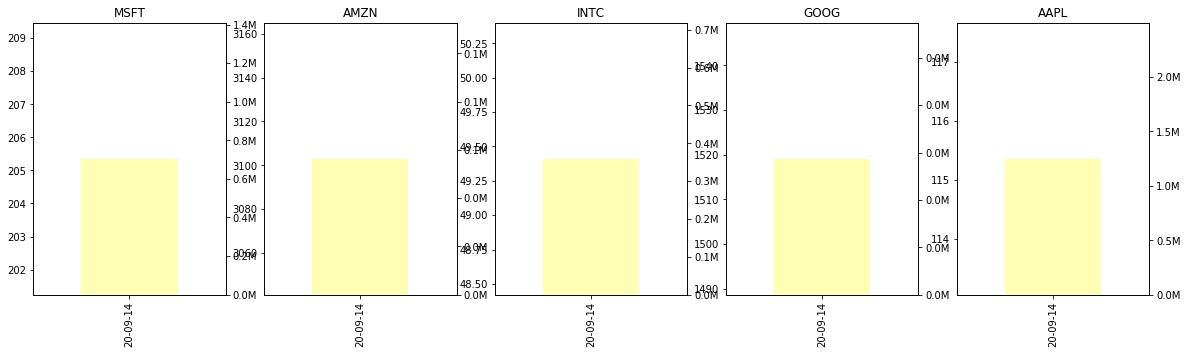

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import Formatter, FuncFormatter
import numpy as np

pricesdf = tsdf[['avg(price)','max(volume)']]
pricesdf.columns = ['price', 'volume']

stock_symbols = pricesdf.index.unique(level='symbol')

class TimeseriesFormatter(Formatter):
    def __init__(self, dates, fmt='%y-%m-%d'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        'Return the label for time x at position pos'
        ind = int(np.round(x))
        if ind >= len(self.dates) or ind < 0:
            return ''

        return self.dates[ind].strftime(self.fmt)

fig, axarr = plt.subplots(1,len(stock_symbols))
for sym, ax in zip(stock_symbols, axarr):
    curr_df = pricesdf.xs(sym, level='symbol')
    curr_df.index = pd.to_datetime(curr_df.index).tz_localize(None)

    # xticks for one day
    xticks = pd.date_range(start=curr_df.index.min(), end=curr_df.index.max(), freq='D')

    # Make sure x-axis has only date ranges for which we have data
    xticks = [curr_df.index.get_loc(x, method='nearest') for x in xticks]
    ax.xaxis.set_major_formatter(TimeseriesFormatter(curr_df.index))
    curr_df.reset_index(inplace=True, drop=True)
    ylim = (curr_df['price'].min() * 0.98, curr_df['price'].max() * 1.02)
    iter_xticks = iter(xticks[1:] + [curr_df.index.max()])
    
    # Color map
    cm = plt.get_cmap('Set3')
    
    # Grey bars every other date
    for a in zip(iter_xticks, iter_xticks):
        ax.fill_between(a, ylim[0], ylim[1], alpha=0.2, color='grey')
    
    # Price
    ax = curr_df['price'].plot(ax=ax,
                               kind='area',
                               xticks=xticks,
                               ylim=ylim,
                               title=sym,
                               rot=45,
                               color=cm.colors[0],
                               figsize=[20,5])

    #Volume
    curr_df['volume'].plot(ax=ax,
                           kind='bar',
                           xticks=xticks,
                           secondary_y=True,
                           color=cm.colors[1])
    ax.right_ax.set_ylim(0,curr_df['volume'].max()*2)
    ax.right_ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: '%0.1fM' % (x*1e-6)))
    ax.right_ax.grid(False)

## Read the Sentiments Feed as Pandas DataFrame
Streaming data generated in by nuclio functions can be read in real-time or historically. It can be distributed to multiple workers for scalability via sharding/partitioning. 

In [13]:
streamdf = client.read(backend='stream', table='stocks/stocks_stream',seek='earliest', shard_id='0')
streamdf.head(15)

,content,link,sentiment,stream_time,symbol,time
seq_number,,,,,,
1,By Yasin Ebrahim\nInvesting.com – The Dow ende...,https://www.investing.com/news/stock-market-ne...,-0.285714,2020-09-15 21:09:19.632706289+00:00,GOOGL,2020-09-15 00:00:00
2,By Stephen Nellis\n(Reuters) - Apple Inc rolle...,https://www.investing.com/news/technology-news...,0.150000,2020-09-15 21:09:19.643533127+00:00,GOOGL,2020-09-15 00:00:00
3,By Yasin Ebrahim\nInvesting.com – The Dow ease...,https://www.investing.com/news/stock-market-ne...,-0.357143,2020-09-15 21:09:19.645611151+00:00,GOOGL,2020-09-15 00:00:00
4,"By Patrick Werr\nMEMPHIS, Egypt (Reuters) - Eg...",https://www.investing.com/news/world-news/egyp...,0.035714,2020-09-15 21:09:19.647624029+00:00,GOOGL,2020-09-15 00:00:00
5,By Ross Kerber and Simon Jessop\nBOSTON/LONDON...,https://www.investing.com/news/stock-market-ne...,-0.272727,2020-09-15 21:09:19.649497096+00:00,GOOGL,2020-09-15 00:00:00
6,WASHINGTON (Reuters) - Alphabet Inc s Google ...,https://www.investing.com/news/technology-news...,-0.181818,2020-09-15 21:09:19.651337688+00:00,GOOGL,2020-09-15 00:00:00
7,By William Schomberg and David Milliken\nLONDO...,https://www.investing.com/news/coronavirus/uk-...,-0.280000,2020-09-15 21:09:19.653244761+00:00,GOOGL,2020-09-15 00:00:00
8,"By Paresh Dave\nOAKLAND, Calif. (Reuters) - Al...",https://www.investing.com/news/commodities-new...,-0.095238,2020-09-15 21:09:19.655195918+00:00,GOOGL,2020-09-14 00:00:00
9,By Kate Abnett\nBRUSSELS (Reuters) - Investors...,https://www.investing.com/news/commodities-new...,0.090909,2020-09-15 21:09:19.657008119+00:00,GOOGL,2020-09-15 00:00:00


## Save Any Data "To Go" as a CSV file (or other formats)

In [9]:
streamdf.to_csv('mystream.csv')